In [1]:
import cv2
import numpy as np

import pandas as pd

from inference import Network
from model_handlers import handle_output
from image_handlers import preprocessing, create_output_image

from matplotlib import pyplot as plt

In [38]:
spModel="./models/single-human-pose-estimation-0001.xml" 
spModelId="SINGLEPOSE"
mpModel="./models/human-pose-estimation-0001.xml"
mpModelId="MULTIPOSE"
CPU_EXT=None
DEVICE="CPU"



image_1="./images/w2.jpg"#capt.png" 

In [39]:
# Detect person

# Create a Network for using the Inference Engine
inference_network = Network()
    
# Load the model in the network, Read network parameters (shape)
n, c, h, w = inference_network.load_model(mpModel, DEVICE, CPU_EXT)

# Read the input image
image = cv2.imread(image_1)
preprocessed_image = preprocessing(image, h, w)

# Perform synchronous inference on the image
inference_network.sync_inference(preprocessed_image)

# Obtain the output of the inference request
output = inference_network.extract_output()

#process output
processed_output = handle_output(mpModelId)(output, image.shape)

input shape:  [1, 3, 256, 456]
input real shape:  (1, 3, 256, 456)


In [40]:
output1 = processed_output

def get_mask(processed_output):
    '''
    Given an input image size and processed output for a semantic mask,
    returns a masks able to be combined with the original image.
    '''
    # Create an empty array for other color channels of mask
    empty = np.zeros(processed_output.shape)
    # Stack to make a Green mask where text detected
    mask = np.dstack((empty, processed_output, empty))

    return mask

output1 = output1[:-1]
for c in range(len(output1)):
    output1[c] = np.where(output1[c]>0.4, (output1[c]-0.4)*100, 0)
# Sum along the "class" axis
output1 = np.sum(output1, axis=0)

# Get semantic mask
pose_mask = get_mask(output1)
# Combine with original image
#imageBk = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#image = cv2.cvtColor(imageBk, cv2.COLOR_GRAY2BGR)
#image = image.astype(int) +
#image= pose_mask.astype(int)

pose_mask.shape

(867, 1300, 3)

In [41]:

#try .... 
output_image = create_output_image(mpModelId, image, processed_output)
cv2.imwrite("./output_net.png", output_image)

True

254


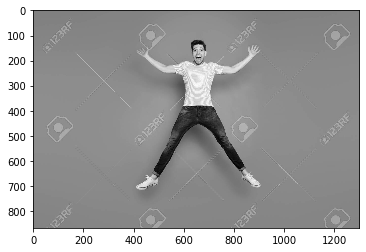

In [42]:
print (output_image.max())
im_rgb = cv2.cvtColor(output_image.astype('uint8'), cv2.COLOR_BGR2RGB)

plt.imshow(im_rgb)

In [43]:
processed_output.max()
#plt.imshow(processed_output[4])


54.391853427886964

0.07920204102993011 0.998046875
(0, 0)


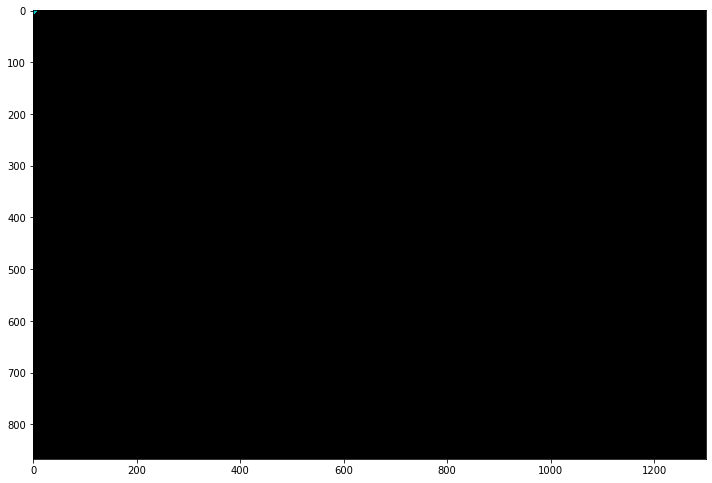

In [66]:
#dibujar articulacion
art=18

artLayer=processed_output[art]
print(artLayer.min(), artLayer.max())
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(artLayer)
print(max_loc)

imout= np.zeros(image.shape)
imout[:,:,1]=artLayer
cv2.circle(imout, max_loc, 3, (0, 200, 200), 5)

imbk=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
imout1=cv2.cvtColor(imbk, cv2.COLOR_GRAY2BGR)
imout=imout.astype(int) + imout1 

fig, ax = plt.subplots(figsize=(10, 7))
ax.imshow(imout)#, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()

AttributeError: 'list' object has no attribute 'len'

In [76]:
# dibujar skeleton

joints, height, width = processed_output.shape

# initialize dataframe of body parts
ixn=['head','left_eye','right_eye','left_ear','right_ear','left_shoulder','right_shoulder','left_elbow',
    'right_elbow','left_wrist', 'right_wrist','left_hip', 'right_hip','left_knee','right_knee', 
    'left_foot', 'right_foot' ]

ixn=['head','neck','right_shoulder','right_elbow','right_wrist','left_shoulder','left_elbow','left_wrist',
     'right_hip','right_knee','right_foot','left_hip','left_knee','left_foot',
     'right_eye','left_eye','right_ear', 'left_ear', 'none']
n=len(ixn)

skeleton=pd.DataFrame(np.zeros((n,2), dtype=np.intc), index=ixn, columns=['x_max1','y_max2'])
points=[]
baseColor=[]
for p in range(n):
    points.append((0,0))
    baseColor.append(( 0, 200, 200))
skeleton['pt_cam1'] = pd.Series(points, index=ixn)
skeleton['base_color'] = pd.Series(baseColor, index=ixn)
for bodyPart in range(joints):
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(processed_output[bodyPart])
    skeleton.iloc[bodyPart, 0:3] = [max_loc[0], max_loc[1], max_loc]

skeleton

,x_max1,y_max2,pt_cam1,base_color
head,650,175,"(650, 175)","(0, 200, 200)"
neck,650,230,"(650, 230)","(0, 200, 200)"
right_shoulder,604,230,"(604, 230)","(0, 200, 200)"
right_elbow,513,230,"(513, 230)","(0, 200, 200)"
right_wrist,467,176,"(467, 176)","(0, 200, 200)"
left_shoulder,718,230,"(718, 230)","(0, 200, 200)"
left_elbow,787,230,"(787, 230)","(0, 200, 200)"
left_wrist,855,202,"(855, 202)","(0, 200, 200)"
right_hip,626,393,"(626, 393)","(0, 200, 200)"
right_knee,558,528,"(558, 528)","(0, 200, 200)"


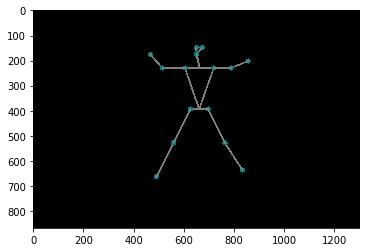

In [77]:

def calcMiddlePoint(p1, p2):
    x1,y1=p1
    x2,y2=p2
    return (min(x1,x2)+int(abs(x2-x1)/2), min(y1,y2)+int(abs(y2-y1)/2))
def calcDistance(p1, p2):
    x1,y1=p1
    x2,y2=p2
    return (int(abs(x2-x1))**2 + int(abs(y2-y1))**2)**0.5

max1d=skeleton['pt_cam1']
colorIx=skeleton['base_color']
bLineColor=(200, 200, 200)#colorIx['head']
imout = np.zeros(image.shape, dtype=np.int8)

if not(max1d.loc['right_eye']==(0,0) or max1d.loc['left_eye']==(0,0)):
    cv2.line(imout, max1d.loc['right_eye'], max1d.loc['left_eye'], bLineColor,5)
    cv2.circle(imout, max1d.loc['right_eye'], 7, colorIx['right_eye'],5)
    cv2.circle(imout, max1d.loc['left_eye'], 7, colorIx['left_eye'],5)
    if (max1d.loc['head']!=(0,0)):
        cv2.line(imout, max1d.loc['right_eye'], max1d.loc['head'], bLineColor,5)
        cv2.line(imout, max1d.loc['left_eye'], max1d.loc['head'], bLineColor,5)

if (max1d.loc['head']!=(0,0)):
    cv2.circle(imout, max1d.loc['head'], 7, colorIx['head'],5)
    
pelvis=(0,0)
if (max1d.loc['left_hip']!=(0,0)):
    cv2.circle(imout, max1d.loc['left_hip'], 7, colorIx['left_hip'],5)
    if (max1d.loc['right_hip']!=(0,0)):
        pelvis = calcMiddlePoint(max1d.loc['left_hip'],max1d.loc['right_hip'])
        cv2.line(imout, max1d.loc['left_hip'], max1d.loc['right_hip'], bLineColor,5)
if (max1d.loc['right_hip']!=(0,0)):
    cv2.circle(imout, max1d.loc['right_hip'], 7, colorIx['right_hip'],5)

#headRad=int(calcDistance(max1d.loc['left_shoulder'],max1d.loc['right_shoulder'])/4)+3
if not(max1d.loc['left_shoulder']==(0,0) or max1d.loc['right_shoulder']==(0,0)):
    cv2.line(imout, max1d.loc['left_shoulder'], max1d.loc['right_shoulder'], bLineColor,5)
    neck = calcMiddlePoint(max1d.loc['left_shoulder'],max1d.loc['right_shoulder'])
    if (max1d.loc['head']!=(0,0)):
        cv2.line(imout, max1d.loc['head'], neck, bLineColor,5)
    if (pelvis!=(0,0)):
        cv2.line(imout, pelvis, max1d.loc['left_shoulder'], bLineColor,5)
        cv2.line(imout, pelvis, max1d.loc['right_shoulder'], bLineColor,5)

if (max1d.loc['left_wrist']!=(0,0)):
    cv2.circle(imout, max1d.loc['left_wrist'], 7, colorIx['left_wrist'],5)
    if (max1d.loc['left_elbow']!=(0,0)):
        cv2.line(imout, max1d.loc['left_elbow'], max1d.loc['left_wrist'], bLineColor,5)
        cv2.circle(imout, max1d.loc['left_elbow'], 7, colorIx['left_elbow'],5)
if (max1d.loc['left_shoulder']!=(0,0)):
    cv2.circle(imout, max1d.loc['left_shoulder'], 7, colorIx['left_shoulder'],5)
    if (max1d.loc['left_elbow']!=(0,0)):
        cv2.line(imout, max1d.loc['left_shoulder'], max1d.loc['left_elbow'], bLineColor,5)

if (max1d.loc['right_wrist']!=(0,0)):
    cv2.circle(imout, max1d.loc['right_wrist'], 7, colorIx['right_wrist'],5)
    if (max1d.loc['right_elbow']!=(0,0)):
        cv2.line(imout, max1d.loc['right_elbow'], max1d.loc['right_wrist'], bLineColor,5)
        cv2.circle(imout, max1d.loc['right_elbow'], 7, colorIx['right_elbow'],5)
if (max1d.loc['right_shoulder']!=(0,0)):
    cv2.circle(imout, max1d.loc['right_shoulder'], 7, colorIx['right_shoulder'],5)
    if (max1d.loc['right_elbow']!=(0,0)):
        cv2.line(imout, max1d.loc['right_shoulder'], max1d.loc['right_elbow'], bLineColor,5)

if (max1d.loc['left_foot']!=(0,0)):
    cv2.circle(imout, max1d.loc['left_foot'], 7, colorIx['left_foot'],5)
    if (max1d.loc['left_knee']!=(0,0)):
        cv2.line(imout, max1d.loc['left_knee'], max1d.loc['left_foot'], bLineColor,5)
        cv2.circle(imout, max1d.loc['left_knee'], 7, colorIx['left_knee'],5)
if not(max1d.loc['left_hip']==(0,0) or max1d.loc['left_knee']==(0,0)):
    cv2.line(imout, max1d.loc['left_hip'], max1d.loc['left_knee'], bLineColor,5)        

if (max1d.loc['right_foot']!=(0,0)):
    cv2.circle(imout, max1d.loc['right_foot'], 7, colorIx['right_foot'],5)
    if (max1d.loc['right_knee']!=(0,0)):
        cv2.line(imout, max1d.loc['right_knee'], max1d.loc['right_foot'], bLineColor,5)
        cv2.circle(imout, max1d.loc['right_knee'], 7, colorIx['right_knee'],5)
if not(max1d.loc['right_hip']==(0,0) or max1d.loc['right_knee']==(0,0)):
    cv2.line(imout, max1d.loc['right_hip'], max1d.loc['right_knee'], bLineColor,5)


plt.imshow(imout)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


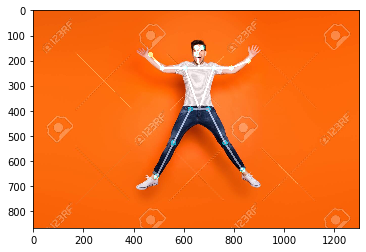

In [78]:

#imout=cv2.add(imout, cv2.cvtColor(image, cv2.COLOR_BGR2RGB), dtype=np.int8)
imout=imout + cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(imout)


In [229]:
mi=np.zeros((16,2))

In [288]:
tuple(max1d.loc['left_shoulder'])

(1253.0, 303.0)

In [289]:
tuple(max1d.loc['left_elbow'])

(1412.0, 393.0)

In [243]:
skeleton.iloc[3,0:2]=(3,2)
skeleton

,x_max,y_max
head,0.0,0.0
left_eye,0.0,0.0
right_eye,0.0,0.0
left_ear,3.0,2.0
right_ear,0.0,0.0
left_shoulder,0.0,0.0
right_shoulder,0.0,0.0
left_elbow,0.0,0.0
right_elbow,0.0,0.0
left_hand,0.0,0.0


In [244]:
skeleton[['x_max']]

,x_max
head,0.0
left_eye,0.0
right_eye,0.0
left_ear,3.0
right_ear,0.0
left_shoulder,0.0
right_shoulder,0.0
left_elbow,0.0
right_elbow,0.0
left_hand,0.0


In [252]:
skeleton.loc['left_ear'][['x_max']]
#skeleton.loc['left_ear'][['x_max']].to_numpy()

x_max    1199.0
Name: left_ear, dtype: float64

In [256]:
skeleton.loc['left_ear'].to_numpy()

array([1199.,  191.])

In [110]:
max1d.iloc[0, 2][1] #= {(1,1)}

0

In [117]:
max1d.loc['right_eye']

(0, 0)

In [114]:
max1d.loc['right_eye'],1

(x_max            704
 y_max            209
 pt_max    (704, 209)
 Name: right_eye, dtype: object,
 1)

In [298]:
tuple(max1d.loc['left_shoulder']) - tuple(max1d.loc['right_shoulder'])

TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'

In [20]:
x1,y1=tuple(max1d.loc['left_shoulder'])
x2,y2=tuple(max1d.loc['right_shoulder'])
neck=(min(x1,x2)+abs(x2-x1), min(y1,y2)+abs(y2-y1))


(1253, 303)

In [153]:
skeleton

,x_max,y_max,pt_max,basecolor
head,1093,213,"(1093, 213)","(0, 200, 200)"
left_eye,1146,191,"(1146, 191)","(0, 200, 200)"
right_eye,1040,191,"(1040, 191)","(0, 200, 200)"
left_ear,1199,191,"(1199, 191)","(0, 200, 200)"
right_ear,1039,191,"(1039, 191)","(0, 200, 200)"
left_shoulder,1253,303,"(1253, 303)","(0, 200, 200)"
right_shoulder,986,281,"(986, 281)","(0, 200, 200)"
left_elbow,1412,393,"(1412, 393)","(0, 200, 200)"
right_elbow,826,348,"(826, 348)","(0, 200, 200)"
left_wrist,1573,461,"(1573, 461)","(0, 200, 200)"


In [83]:
#tuple(max1d)
points=[]
for p in range(4):
    points.append((0,0))
points

[(0, 0), (0, 0), (0, 0), (0, 0)]